#### The objective is to corrently classify fraudulent transactions from legitimate transactions.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_pipeline_imb

/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
#Import the file into a Pandas DataFrame as cc (stands for credit cards)
cc = pd.read_csv('creditcard.csv')

0    284315
1       492
Name: Class, dtype: int64


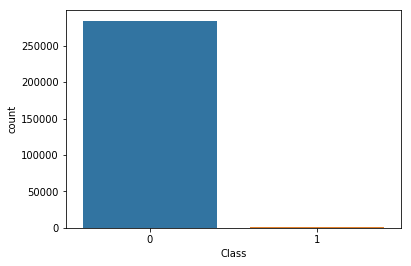

In [3]:
#The data is increadibly inbalanced. This indicates that over/under sampling is needed.
print(cc.Class.value_counts());
sns.countplot(cc.Class);

#### Naive Models

In [4]:
#Starting out with a naive train_test_split
X = cc.drop(columns='Class')
y = cc['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)

In [5]:
#Run models without any feature engineering or over/undersampling.
scores = []
for k in range(1,11):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_kpred = knn.predict(X_test)
    scores.append(accuracy_score(y_test, y_kpred))
    
# The KNN accuracy scores (and accuracy scores in general) tell me nothing.
scores

[0.9981180303924047,
 0.9983708322799921,
 0.9983286986320609,
 0.9983427431813713,
 0.9983427431813713,
 0.9982865649841297,
 0.9982725204348193,
 0.9982584758855089,
 0.9982725204348193,
 0.9982584758855089]

In [6]:
#The Dummy Classifier confirms my suspicions. Accuracy scores should not be taken into consideration.
#Precision and recall are better metrics for classifing credit card fraud.
DC = DummyClassifier(random_state=7)
DC.fit(X_train, y_train)
y_pred = DC.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

0.9966152636161906
0.008547008547008548
0.007936507936507936


In [7]:
logreg = LogisticRegression(random_state=7)
logreg.fit(X_train, y_train)
y_lpred = logreg.predict(X_test)

print(precision_score(y_test, y_lpred))
print(recall_score(y_test, y_lpred))

/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7058823529411765
0.5714285714285714


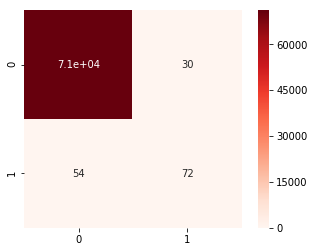

In [8]:
#Logistic Regression does not perform well without any tampering. Has a hard time picking True positives
logreg_confusion = confusion_matrix(y_test,y_lpred)
sns.heatmap(logreg_confusion,cmap=plt.cm.Reds, annot=True, square=True)

In [9]:
NB = GaussianNB()
NB.fit(X_train, y_train)
y_nbpred = NB.predict(X_test)

print(precision_score(y_test, y_nbpred))
print(recall_score(y_test, y_nbpred))

0.14590747330960854
0.6507936507936508


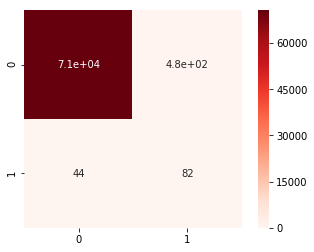

In [10]:
#Naive Bays predicts too many false positives.
NB_confusion = confusion_matrix(y_test,y_nbpred)
sns.heatmap(NB_confusion, cmap=plt.cm.Reds, annot=True, square=True)

In [11]:
#I know that the Decision Tree Classifier has a tendency to overfit. I should be cautious with the metrics.
DTC = DecisionTreeClassifier(random_state=7)
DTC.fit(X_train, y_train)
y_dtcpred = DTC.predict(X_test)

print(precision_score(y_test, y_dtcpred))
print(recall_score(y_test, y_dtcpred))

0.7538461538461538
0.7777777777777778


In [12]:
#Ensembling returns higher scores but it's still not great. There are fewer false positives and false negatives
#but still a significant lack of True Positives.
RFC = RandomForestClassifier(random_state=7)
RFC.fit(X_train, y_train)
y_rfcpred = RFC.predict(X_test)

print(precision_score(y_test, y_rfcpred))
print(recall_score(y_test, y_rfcpred))

/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.908256880733945
0.7857142857142857


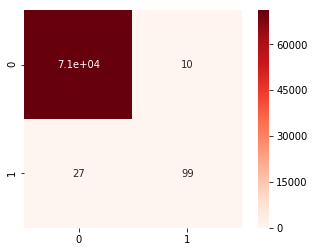

In [13]:
RFC_confusion = confusion_matrix(y_test,y_rfcpred)
sns.heatmap(RFC_confusion, cmap=plt.cm.Reds, annot=True, square=True)

In [14]:
feature_importances = pd.DataFrame(RFC.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance',  ascending=False)
feature_importances

,importance
V14,0.191513
V10,0.134384
V16,0.092371
V12,0.070892
V17,0.070127
V9,0.068363
V11,0.063322
V4,0.038976
V6,0.038896
V7,0.029901


In [15]:
#One more test before messing with the imported data.
svc = LinearSVC(random_state=7)
svc.fit(X_train, y_train)
y_svcpred = svc.predict(X_test)

print(precision_score(y_test, y_svcpred))
print(recall_score(y_test, y_svcpred))

0.6190476190476191
0.10317460317460317


/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


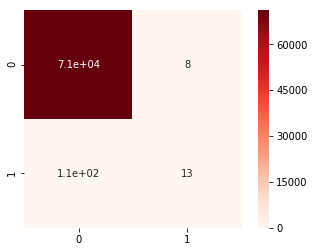

In [16]:
#As the heat map shows, LinearSVC gives too many false negatives(people with fraud recording as ligitimate.)
#Only 13 True positives.
svc_confusion = confusion_matrix(y_test, y_svcpred)
sns.heatmap(svc_confusion, cmap=plt.cm.Reds, annot=True, square=True)

First I will create an 'Hours' in the day to give a better perspective. This will give me insight if Time really is not that important.

In [17]:
cc['Hour'] = cc['Time'].apply(lambda x: np.ceil(float(x)/3600) % 24)
cc.pivot_table(values='Amount',index='Hour',columns='Class',aggfunc='count').head()

Class,0,1
Hour,,
0.0,10919,21
1.0,7687,6
2.0,4212,10
3.0,3269,57
4.0,3476,17


In [18]:
#Let's try Random Forest again to see if time will be a major factor.
X = cc.drop(columns=['Class', 'Time'])
y = cc['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)

RFC2 = RandomForestClassifier(random_state=7)
RFC2.fit(X_train, y_train)
y_rfc2pred = RFC2.predict(X_test)

print(precision_score(y_test, y_rfc2pred))
print(recall_score(y_test, y_rfc2pred))

/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9181818181818182
0.8015873015873016


,importance
V12,0.234828
V17,0.152739
V14,0.109930
V10,0.108138
V11,0.030998


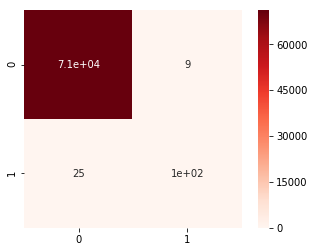

In [37]:
#Looks like I'm wrong.
RFC2_confusion = confusion_matrix(y_test,y_rfc2pred)
sns.heatmap(RFC2_confusion, cmap=plt.cm.Reds, annot=True, square=True)

feature_importances = pd.DataFrame(RFC2.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance',  ascending=False)
feature_importances.head()

In [20]:
#Let's oversample using Random Over Sample and Undersample using Random Under Sample
ROS_pipeline = make_pipeline_imb(RandomOverSampler(random_state=7), RFC)
ROS_model = ROS_pipeline.fit(X_train, y_train)
ROS_pred = ROS_model.predict(X_test)

print(accuracy_score(y_test, ROS_pred))
print(precision_score(y_test, ROS_pred))
print(recall_score(y_test, ROS_pred))

0.9995084407741356
0.9252336448598131
0.7857142857142857


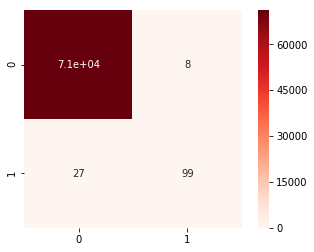

In [21]:
ROS_confusion = confusion_matrix(y_test,ROS_pred)
sns.heatmap(ROS_confusion, cmap=plt.cm.Reds, annot=True, square=True)

In [43]:
feature_importances = pd.DataFrame(RFC.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance',  ascending=False)
feature_importances.head()

,importance
V4,0.188369
V10,0.173236
V14,0.170248
V12,0.138004
V17,0.069142


In [23]:
#Undersampling kills the precision of the model.
RUS_pipeline = make_pipeline_imb(RandomUnderSampler(random_state=7), RFC)
RUS_model = RUS_pipeline.fit(X_train, y_train)
RUS_pred = RUS_model.predict(X_test)

print(accuracy_score(y_test, RUS_pred))
print(precision_score(y_test, RUS_pred))
print(recall_score(y_test, RUS_pred))

0.9662509480070784
0.045871559633027525
0.9126984126984127


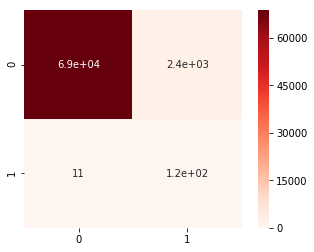

In [24]:
RUS_confusion = confusion_matrix(y_test,RUS_pred)
sns.heatmap(RUS_confusion, cmap=plt.cm.Reds, annot=True, square=True)

In [25]:
print(roc_auc_score(y_test, ROS_pred))
print(roc_auc_score(y_test, RUS_pred))

0.8928008650699853
0.939522147989141


In [26]:
# Label Binarizer instead of OneHotIncoding
lb = preprocessing.LabelBinarizer()
lb.fit(y_train)
cross_paccuracy = cross_val_predict(ROS_model, X_train, y_train, cv=4)
print('')
cross_accuracy = cross_val_score(ROS_model, X_train, y_train, cv=4)
cross_precision = cross_val_score(ROS_model, X_train, y_train, cv=4, scoring='precision')
cross_recall = cross_val_score(ROS_model, X_train, y_train, cv=4, scoring='recall')

In [27]:
print(np.mean(cross_paccuracy))
print('')
print(np.mean(cross_accuracy))
print(np.mean(cross_precision))
print(np.mean(cross_recall))

0.0013716907375763677

0.9995458912836931
0.9589917434597068
0.7678272814142378


In [28]:
important_features = cc[['V4', 'V11', 'V10', 'V12', 'V14', 'V17', 'Amount', 'Class']].copy()
important_features

,V4,V11,V10,V12,V14,V17,Amount,Class
0,1.378155,-0.551600,0.090794,-0.617801,-0.311169,0.207971,149.62,0
1,0.448154,1.612727,-0.166974,1.065235,-0.143772,-0.114805,2.69,0
2,0.379780,0.624501,0.207643,0.066084,-0.165946,1.109969,378.66,0
3,-0.863291,-0.226487,-0.054952,0.178228,-0.287924,-0.684093,123.50,0
4,0.403034,-0.822843,0.753074,0.538196,-1.119670,-0.237033,69.99,0
5,-0.168252,1.341262,-0.371407,0.359894,-0.137134,-0.058133,3.67,0
6,1.202613,-1.416907,-0.099254,-0.153826,0.167372,0.002821,4.99,0
7,-0.492199,-0.619468,1.249376,0.291474,-1.323865,-1.222127,40.80,0
8,-0.271526,-0.705117,-0.410430,-0.110452,0.074355,-0.499768,93.20,0
9,-0.222187,1.017614,-0.366846,0.836390,-0.443523,-0.540980,3.68,0


In [29]:
X_new = important_features.drop(columns='Class')
y_new = important_features['Class']
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new, y_new, test_size=0.25, random_state=7)

In [30]:
# Testing Logistical Regression one more time.
logreg_new = LogisticRegression(random_state=7, class_weight={1:0.5})
logreg_new.fit(X_new_train, y_new_train)
y_new_lpred = logreg_new.predict(X_new_test)

print(precision_score(y_new_test, y_new_lpred))
print(recall_score(y_new_test, y_new_lpred))
print(roc_auc_score(y_new_test, y_new_lpred))

/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8695652173913043
0.47619047619047616
0.7380319255846861


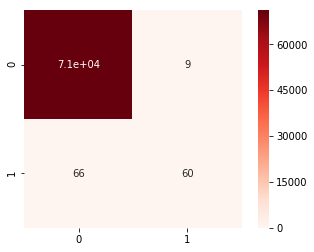

In [31]:
lf_confusion = confusion_matrix(y_test,y_new_lpred)
sns.heatmap(lf_confusion, cmap=plt.cm.Reds, annot=True, square=True)

In [32]:
# Trying Random Forest again with 
RFC_new = RandomForestClassifier(random_state=7,class_weight={1:0.3})
ROS_new_pipeline = make_pipeline_imb(RandomOverSampler(random_state=7), RFC_new)
ROS_new_model = ROS_new_pipeline.fit(X_new_train, y_new_train)
ROS_new_pred = ROS_new_model.predict(X_new_test)

/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [33]:
print(precision_score(y_new_test, ROS_new_pred))
print(recall_score(y_new_test, ROS_new_pred))
print(roc_auc_score(y_new_test, ROS_new_pred))

0.9017857142857143
0.8015873015873016
0.9007162688363094


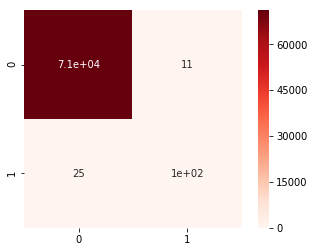

In [34]:
final_confusion = confusion_matrix(y_test,ROS_new_pred)
sns.heatmap(final_confusion, cmap=plt.cm.Reds, annot=True, square=True)

With oversampling, eliminating irrelavent features, and using a weight of 0.3 almost all False positives and false negatives have been eliminatied. this is significantly better than the bare bones approach of throwing the data into non-specific models.

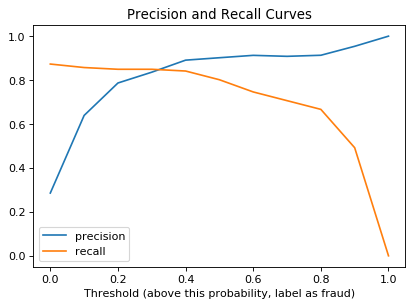

In [35]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_new_test, ROS_new_model.predict_proba(X_new_test)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

ROC AUC score =  0.9361696556424735


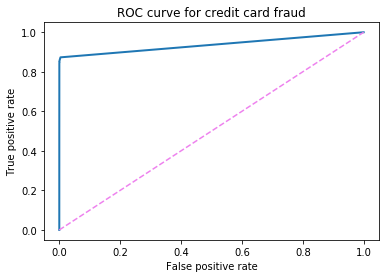

In [36]:
fpr, tpr, thresholds = roc_curve(y_new_test, ROS_new_model.predict_proba(X_new_test)[:,1]);
plt.plot(fpr, tpr,lw=2);
plt.plot([0,1],[0,1],c='violet',ls='--');
plt.xlim([-0.05,1.05]);
plt.ylim([-0.05,1.05]);


plt.xlabel('False positive rate');
plt.ylabel('True positive rate');
plt.title('ROC curve for credit card fraud');
print("ROC AUC score = ", roc_auc_score(y_new_test, ROS_new_model.predict_proba(X_new_test)[:,1]));